<a href="https://colab.research.google.com/github/cseveriano/spatio-temporal-forecasting/blob/master/notebooks/thesis_experiments/20200824_Wind_Energy_GEFCOM_Univariate_SSA_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U git+https://github.com/cseveriano/spatio-temporal-forecasting
!pip3 install -U hyperopt
!pip install pyts

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-oz86ro_m
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-oz86ro_m
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=207416 sha256=7f50999815c6f17ac0a99381169a141f002cd1f28e64225e003dcf94bfb94134
  Stored in directory: /tmp/pip-ephem-wheel-cache-1eemi11d/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS
  Cloning https://github.com/cseveriano/spatio-temporal-forecasting to /tmp/pip-req-build-9wmyefp6
  Running command git clone -q https://github.com/cseveriano/spatio-temporal-forecasting /tmp/pip-req-build-9wmyefp6
  Created wheel for spatio-temporal-forecasting: filename=spatio_temporal_forecasting-1.0-cp36-none-any.whl size=55633 sha256=1069ca6f502b3ef7224955b48239ad24450e3bf0b507b3a6e88155d685b71cf4
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_y56s23/wheels/d2/1f/6f/439795864246039ef36c6a3c88edf7935c803c2cf97133066a
Succes

## Aux Functions

In [ ]:
import datetime

def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]


def ssa_decomposition(df, period=144, embedding_dim=15, component_threshold=3):
  main_inds = [i for i in range(component_threshold)]
  res_inds = [i for i in range(component_threshold, embedding_dim)]

  groups = [main_inds, res_inds]

  stations = [c for c in df.columns if c not in ['zen', 'Ics']]
  
  clean_df = pd.DataFrame(columns = stations, index = df.index)
  residual_df = pd.DataFrame(columns = stations, index = df.index)

  for s in stations:
    X = np.array(df[s].values)
    X = X.reshape(1,len(X))
    # Singular Spectrum Analysis
    ssa = SingularSpectrumAnalysis(window_size=embedding_dim, groups=groups)
    X_ssa = ssa.fit_transform(X)

    clean_df[s] = X_ssa[0]
    residual_df[s] = X_ssa[1]
  return clean_df, residual_df

import datetime

def getRollingWindow(index):
    pivot = index
    train_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=20)
    train_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    test_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    test_end = pivot.strftime('%Y-%m-%d')
    
    return train_start, train_end, test_start, test_end

def calculate_rolling_error(cv_name, df, forecasts, order_list):
    cv_results = pd.DataFrame(columns=['Split', 'RMSE', 'SMAPE', 'U'])

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    for i in np.arange(len(forecasts)):

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        test = df[test_start : test_end]
    
        yhat = forecasts[i]
        order = order_list[i]
        
        rmse = Measures.rmse(test[target_station].iloc[order:], yhat[:-1])
        
        smape = Measures.smape(test[target_station].iloc[order:], yhat[:-1])
        
        res = {'Split' : index.strftime('%Y-%m-%d') ,'RMSE' : rmse, 'SMAPE' : smape}
        cv_results = cv_results.append(res, ignore_index=True)
        cv_results.to_csv(cv_name+".csv")        

        index = index + datetime.timedelta(days=7)

def reconstruct_ssa_series(clean, residual):
    return [r + c for r, c in zip(residual,clean)]

def get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual):
    
    forecasts_final = []
    order_list = []
    
    for i in np.arange(len(forecasts_clean)):
        f_clean = denormalize(forecasts_clean[i], min_clean, max_clean)
        f_residual = denormalize(forecasts_residual[i], min_residual, max_residual)

        o_clean = order_list_clean[i]
        o_residual = order_list_residual[i]

        max_order = max(o_clean, o_residual)

        f_final = reconstruct_ssa_series(f_clean[max_order-o_clean:], f_residual[max_order-o_residual:])
        
        forecasts_final.append(f_final)
        order_list.append(max_order)
        
    return forecasts_final, order_list

## Load Dataset

In [ ]:
import pandas as pd
import numpy as np
from hyperopt import hp
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
import math
from pyFTS.benchmarks import Measures
from pyts.decomposition import SingularSpectrumAnalysis
from google.colab import files
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#Set target and input variables 
target_station = 'wp1'

df = pd.read_csv('https://query.data.world/s/3zx2jusk4z6zvlg2dafqgshqp3oao6',  parse_dates=['date'], index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m%d%H")

interval = ((df.index >= '2009-07') & (df.index <= '2010-08'))
df = df.loc[interval]

df_ssa_clean, df_ssa_residual = ssa_decomposition(df)

#Normalize Data

# Save Min-Max for Denorm
min_raw = df[target_station].min()
min_clean = df_ssa_clean[target_station].min()
min_residual = df_ssa_residual[target_station].min()

max_raw = df[target_station].max()
max_clean = df_ssa_clean[target_station].max()
max_residual = df_ssa_residual[target_station].max()

# Perform Normalization
norm_df_ssa_clean = normalize(df_ssa_clean)
norm_df_ssa_residual = normalize(df_ssa_residual)


# Tuning split
tuning_ssa_clean = norm_df_ssa_clean["2009-07-01":"2009-07-31"]
tuning_ssa_residual = norm_df_ssa_residual["2009-07-01":"2009-07-31"]

norm_df_ssa_clean = norm_df_ssa_clean["2009-08-01":"2010-08-30"]
norm_df_ssa_residual = norm_df_ssa_residual["2009-08-01":"2010-08-30"]
df = df["2009-08-01":"2010-08-30"]

### Persistence

In [ ]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

def rolling_cv_persistence(df, step):

    forecasts = []
    lags_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]
    
        yhat = persistence_forecast(train[target_station], test[target_station], step)        
        
        lags_list.append(1)
        forecasts.append(yhat)

    return forecasts, lags_list

In [ ]:
forecasts_clean, order_list_clean = rolling_cv_persistence(norm_df_ssa_clean, 1)
forecasts_residual, order_list_residual = rolling_cv_persistence(norm_df_ssa_residual, 1)
forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_persistence", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

In [ ]:
files.download('rolling_cv_wind_persistence.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Univariate MLP

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### MLP Tuning

In [ ]:
mlp_space = {'choice':

   hp.choice('num_layers',
             [
                 {'layers': 'two',
                 },

                 {'layers': 'three',

                   'units3': hp.choice('units3', [8, 16, 64, 128, 256, 512]),
                   'dropout3': hp.choice('dropout3', [0, 0.25, 0.5, 0.75])
                  }

             ]),
   'units1': hp.choice('units1', [8, 16, 64, 128, 256, 512]),
   'units2': hp.choice('units2', [8, 16, 64, 128, 256, 512]),

   'dropout1': hp.choice('dropout1', [0, 0.25, 0.5, 0.75]),
   'dropout2': hp.choice('dropout2', [0, 0.25, 0.5, 0.75]),

   'batch_size': hp.choice('batch_size', [28, 64, 128, 256, 512]),
   'order': hp.choice('order', [1, 2, 4, 8]),
   'input': hp.choice('input', [target_station]),
   'output': hp.choice('output', [target_station]),
   'epochs': hp.choice('epochs', [100, 200, 300])}


In [ ]:
def mlp_tuning(train_df, test_df, params):
    _input = [target_station]
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(_input)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df[_input].values, n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input].values, n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values

    # design network
    model = Sequential()
    model.add(Dense(params['units1'], activation='relu', input_dim=train_X.shape[1]))
    model.add(Dense(params['units2'], activation='relu'))
    if params['choice']['layers'] == 'three':
      model.add(Dense(params['choice']['units3'], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # includes the call back object
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=_batch_size, verbose=False, shuffle=False)

    # predict the test set
    forecast = model.predict(test_X, verbose=False)

    forecast = [f[0] for f in forecast]

    return forecast


In [ ]:
methods = []
methods.append(("EXP_WIND_MLP", mlp_tuning, mlp_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_ssa_residual, train_split, Measures.rmse, max_evals=30, resample=None)

Running experiment: EXP_WIND_MLP
{'batch_size': 512, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.75, 'epochs': 200, 'input': 'wp1', 'order': 4, 'output': 'wp1', 'units1': 8, 'units2': 256}
Error : 0.04831706912984902
{'batch_size': 128, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.25, 'epochs': 200, 'input': 'wp1', 'order': 2, 'output': 'wp1', 'units1': 64, 'units2': 512}
Error : 0.04851659340185528
{'batch_size': 512, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.25, 'epochs': 200, 'input': 'wp1', 'order': 2, 'output': 'wp1', 'units1': 16, 'units2': 16}
Error : 0.05212544284366126
{'batch_size': 256, 'choice': {'dropout3': 0, 'layers': 'three', 'units3': 8}, 'dropout1': 0.25, 'dropout2': 0.5, 'epochs': 200, 'input': 'wp1', 'order': 4, 'output': 'wp1', 'units1': 8, 'units2': 128}
Error : 0.04779186996272765
{'batch_size': 512, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.25, 'epochs': 200, 'input': 'wp1', 'order': 8, 'output':

Best params: \
\
mlp SSA clean: \
 {'batch_size': 256, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.75, 'epochs': 300, 'input': 'wp1', 'order': 4, 'output': 'wp1', 'units1': 512, 'units2': 256} \
\
mlp SSA residual: \
 {'batch_size': 128, 'choice': {'layers': 'two'}, 'dropout1': 0, 'dropout2': 0, 'epochs': 300, 'input': 'wp1', 'order': 8, 'output': 'wp1', 'units1': 256, 'units2': 64} \

#### MLP Forecasting

In [ ]:
def mlp_forecast(train_df, test_df, params):


    _input = [target_station]
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(_input)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps


    train_reshaped_df = series_to_supervised(train_df[_input].values, n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input].values, n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values
    
    # design network
    model = Sequential()
    model.add(Dense(params['units1'], activation='relu', input_dim=train_X.shape[1]))
    model.add(Dense(params['units2'], activation='relu'))
    if params['choice']['layers'] == 'three':
      model.add(Dense(params['choice']['units3'], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')


    # fit network
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=_batch_size, verbose=False, shuffle=False)
    
    forecast = model.predict(test_X)
    
    fcst = [f[0] for f in forecast]

    return fcst

def rolling_cv_mlp_uni(df, params):
    
    lags_list = []
    forecasts = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]


        # Perform forecast
        yhat = mlp_forecast(train[[target_station]], test[[target_station]], params)
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        lags_list.append(params['order'])
        forecasts.append(yhat)

    return forecasts, lags_list

In [ ]:
# Enter best params
params_clean = {'batch_size': 256, 'choice': {'layers': 'two'}, 'dropout1': 0.5, 'dropout2': 0.75, 'epochs': 300, 'input': 'wp1', 'order': 4, 'output': 'wp1', 'units1': 512, 'units2': 256}

params_residual = {'batch_size': 128, 'choice': {'layers': 'two'}, 'dropout1': 0, 'dropout2': 0, 'epochs': 300, 'input': 'wp1', 'order': 8, 'output': 'wp1', 'units1': 256, 'units2': 64}

forecasts_clean, order_list_clean = rolling_cv_mlp_uni(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_mlp_uni(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_mlp_uni", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

In [ ]:
files.download('rolling_cv_wind_mlp_uni.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conventional (Song and Chissom) FTS

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import song

#### FTS Parameter Tuning

In [ ]:
fts_space = {'partitioner': hp.choice('partitioner', [Grid.GridPartitioner, Entropy.EntropyPartitioner]),
        'npartitions': hp.choice('npartitions', [10, 50,100]),
        'order': hp.choice('order', [1]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def fts_forecast(train_df, test_df, params):
    _partitioner = params['partitioner']
    _npartitions = params['npartitions']
    _order = 1
    _input = params['input']
    _step = params.get('step',1)

    fuzzy_sets = _partitioner(data=train_df[_input].values, npart=_npartitions)
    model = song.ConventionalFTS(partitioner=fuzzy_sets)

    model.fit(train_df[_input].values)
    forecast = model.predict(test_df[_input].values, steps_ahead=_step)

    return forecast[:-1]

In [ ]:
methods = []
methods.append(("EXP_OAHU_FTS", fts_forecast, fts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_ssa_residual, train_split, Measures.rmse, max_evals=30, resample=None)

Running experiment: EXP_OAHU_FTS
{'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.06503983297992211
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.05778839916145659
{'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.05281573525856597
{'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.05281573525856597
{'input': 'wp1', 'npartitions': 50, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error : 0.06409304995778142
{'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.052815735

Best params: \
\
FTS SSA clean: \
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>} \
\
FTS SSA residual: \
{'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>} \

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import song


def rolling_cv_fts(df, params):

    _order = params['order']

    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast
        yhat = fts_forecast(train, test, params)
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        order_list.append(_order)
        forecasts.append(yhat)

    return forecasts, order_list

#### FTS Forecasting

In [ ]:
params_clean = {'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': Grid.GridPartitioner}

params_residual = {'input': 'wp1', 'npartitions': 100, 'order': 1, 'output': 'wp1', 'partitioner': Entropy.EntropyPartitioner}


forecasts_clean, order_list_clean = rolling_cv_fts(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_fts(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_fts", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

In [ ]:
files.download('rolling_cv_wind_fts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### High Order FTS

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import hofts

#### HOFTS Parameter Tuning

In [ ]:
hofts_space = {'partitioner': hp.choice('partitioner', [Grid.GridPartitioner, Entropy.EntropyPartitioner]),
        'npartitions': hp.choice('npartitions', [10, 50,100, 150]),
        'order': hp.choice('order', [1,2]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def hofts_forecast(train_df, test_df, params):
    _partitioner = params['partitioner']
    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)

    fuzzy_sets = _partitioner(data=train_df[_input].values, npart=_npartitions)
    model = hofts.HighOrderFTS(order=_order)

    model.fit(train_df[_input].values, order=_order, partitioner=fuzzy_sets)
    forecast = model.predict(test_df[_input].values, steps_ahead=_step)

    return forecast

In [ ]:
methods = []
methods.append(("EXP_WIND_HOFTS", hofts_forecast, hofts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_ssa_residual, train_split, Measures.rmse, max_evals=30, resample=None)

Running experiment: EXP_WIND_HOFTS
{'input': 'wp1', 'npartitions': 150, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.05935016391365774
{'input': 'wp1', 'npartitions': 100, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.05699445263351666
{'input': 'wp1', 'npartitions': 50, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.07380706767887073
{'input': 'wp1', 'npartitions': 50, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.07380706767887073
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Entropy.EntropyPartitioner'>}
Error : 0.0528360400554714
{'input': 'wp1', 'npartitions': 100, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}
Error :

Best params: \
\
HOFTS SSA clean: \
{'input': 'wp1', 'npartitions': 100, 'order': 2, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>}\
\
HOFTS SSA residual: \
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': <class 'pyFTS.partitioners.Grid.GridPartitioner'>} \

In [ ]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import hofts


def rolling_cv_hofts(df, params):

    _order = params['order']

    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast
        yhat = hofts_forecast(train, test, params)
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        order_list.append(_order)
        forecasts.append(yhat)

    return forecasts, order_list

In [ ]:
params_clean = {'input': 'wp1', 'npartitions': 100, 'order': 2, 'output': 'wp1', 'partitioner': Grid.GridPartitioner}

params_residual = {'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1', 'partitioner': Grid.GridPartitioner}


forecasts_clean, order_list_clean = rolling_cv_hofts(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_hofts(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_hofts", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

In [ ]:
files.download('rolling_cv_wind_hofts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### NSFTS

In [ ]:
from pyFTS.models.nonstationary import common, perturbation, partitioners as nspart
from pyFTS.models.nonstationary import nsfts, util as nsUtil

#### Parameter Tuning

In [ ]:
nsfts_space = {'npartitions': hp.choice('npartitions', [10, 30, 50, 100, 150]),
        'order': hp.choice('order', [1]),
        'input': hp.choice('input', [target_station]),
        'output': hp.choice('output', [target_station])}

def nsfts_forecast(train_df, test_df, params):
    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)
    
    nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train_df[_input].values, npart=_npartitions, transformation=None)
    model = nsfts.NonStationaryFTS(partitioner=nsfs, order=_order)
    
    model.fit(train_df[_input].values)

    forecast = model.predict(test_df[_input].values)
    forecast = forecast[:-1]
    return forecast

In [ ]:
methods = []
methods.append(("EXP_WIND_NSFTS", nsfts_forecast, nsfts_space))
train_split = 0.6
parameter_tuning.run_search(methods, tuning_ssa_residual, train_split, Measures.rmse, max_evals=10, resample=None)

Running experiment: EXP_WIND_NSFTS
{'input': 'wp1', 'npartitions': 50, 'order': 1, 'output': 'wp1'}
Error : 0.05688019103565743
{'input': 'wp1', 'npartitions': 150, 'order': 1, 'output': 'wp1'}
Error : 0.06447110342869575
{'input': 'wp1', 'npartitions': 50, 'order': 1, 'output': 'wp1'}
Error : 0.05688019103565743
{'input': 'wp1', 'npartitions': 30, 'order': 1, 'output': 'wp1'}
Error : 0.05852211244563932
{'input': 'wp1', 'npartitions': 150, 'order': 1, 'output': 'wp1'}
Error : 0.06447110342869575
{'input': 'wp1', 'npartitions': 50, 'order': 1, 'output': 'wp1'}
Error : 0.05688019103565743
{'input': 'wp1', 'npartitions': 150, 'order': 1, 'output': 'wp1'}
Error : 0.06447110342869575
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1'}
Error : 0.055563122054530005
{'input': 'wp1', 'npartitions': 30, 'order': 1, 'output': 'wp1'}
Error : 0.05852211244563932
{'input': 'wp1', 'npartitions': 50, 'order': 1, 'output': 'wp1'}
Error : 0.05688019103565743
100%|██████████| 10/10 [00:42<0

Best params: \
\
HOFTS SSA clean: \
{'input': 'wp1', 'npartitions': 30, 'order': 1, 'output': 'wp1'}\
\
HOFTS SSA residual: \
{'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1'} \

#### NSFTS Forecasting

In [ ]:
def rolling_cv_nsfts(df, params):
    
    forecasts = []
    order_list = []

    _npartitions = params['npartitions']
    _order = params['order']
    _input = params['input']
    _step = params.get('step',1)

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]
    first_time = True

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast

        # In the first time, the model is trained. 
        # For the next iterations, training subset is used to evolve the model
        if first_time:
          nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train[_input].values, npart=_npartitions, transformation=None)
          model = nsfts.NonStationaryFTS(partitioner=nsfs, order=_order)
          model.fit(train[_input].values)
          first_time = False

        forecast = model.predict(test[_input].values)
        #forecast = forecast[:-1]
        
        order_list.append(params['order'])
        forecasts.append(forecast)

    return forecasts, order_list

In [ ]:
params_clean = {'input': 'wp1', 'npartitions': 30, 'order': 1, 'output': 'wp1'}
params_residual = {'input': 'wp1', 'npartitions': 10, 'order': 1, 'output': 'wp1'}


forecasts_clean, order_list_clean = rolling_cv_nsfts(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_nsfts(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_nsfts", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

In [ ]:
files.download('rolling_cv_wind_nsfts.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results Analysis

In [ ]:
files.upload()

Saving rolling_cv_wind_hofts.csv to rolling_cv_wind_hofts.csv


{'rolling_cv_wind_hofts.csv': b',Split,RMSE,SMAPE,U\n0,2009-08-01,0.04072680759524921,31.262196539345492,\n1,2009-08-08,0.04335739298121313,64.99474558108422,\n2,2009-08-15,0.025168151789516847,28.12228297435371,\n3,2009-08-22,0.049811083459788054,24.690924979150605,\n4,2009-08-29,0.03254160627773798,21.421890408521286,\n5,2009-09-05,0.11040776833365082,16.670688040976334,\n6,2009-09-12,0.096785570443263,28.23886775787521,\n7,2009-09-19,0.08329540999379147,39.244049496348794,\n8,2009-09-26,0.07454346446062926,41.49850566997031,\n9,2009-10-03,0.0480972363658258,26.312081145672522,\n10,2009-10-10,0.05220169513299872,25.152073524894643,\n11,2009-10-17,0.059208228633507366,18.287599685222244,\n12,2009-10-24,0.062004997627969176,11.023792480750954,\n13,2009-10-31,0.04244832358442269,32.283605130743446,\n14,2009-11-07,0.06867807984445784,13.692231766612503,\n15,2009-11-14,0.0704175627372447,11.984941839261984,\n16,2009-11-21,0.046515529658593804,28.062014584697277,\n17,2009-11-28,0.043252824

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
def createBoxplot(filename, data, xticklabels, ylabel):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)
    
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#AACCFF' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#FFE680', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    ## Custom x-axis labels
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    plt.show()
    fig.savefig(filename, bbox_inches='tight')

In [ ]:
fts_results = pd.read_csv("rolling_cv_wind_fts.csv")
hofts_results = pd.read_csv("rolling_cv_wind_hofts.csv")
mlp_results = pd.read_csv("rolling_cv_wind_mlp_uni.csv")
nsfts_results = pd.read_csv("rolling_cv_wind_nsfts.csv")
persistence_results = pd.read_csv("rolling_cv_wind_persistence.csv")

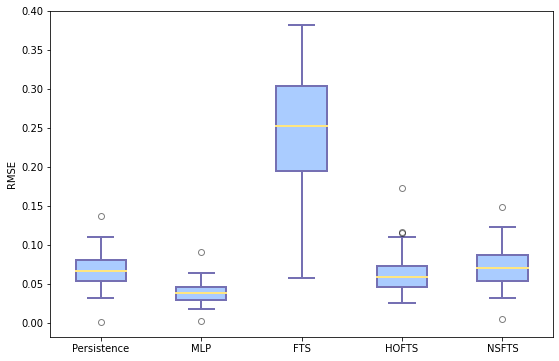

In [ ]:
metric = 'RMSE'
results_data = [persistence_results[metric],mlp_results[metric], fts_results[metric], hofts_results[metric], nsfts_results[metric]]
xticks = ['Persistence','MLP','FTS','HOFTS','NSFTS']

ylab = 'RMSE'
createBoxplot("nsfts_boxplot_rmse_wind", results_data, xticks, ylab)

In [ ]:
metric = 'RMSE'
rmse_df = pd.DataFrame(columns=['Persistence','MLP','FTS','HOFTS','NSFTS'])

rmse_df["Persistence"] = persistence_results[metric]
rmse_df["MLP"] = mlp_results[metric]
rmse_df["FTS"] = fts_results[metric]
rmse_df["HOFTS"] = hofts_results[metric]
rmse_df["NSFTS"] = nsfts_results[metric]

In [ ]:
print("Mean")
print(rmse_df.mean())
print("std")
print(rmse_df.std())

Mean
Persistence   0.0684
MLP           0.0392
FTS           0.2475
HOFTS         0.0640
NSFTS         0.0724
dtype: float64
std
Persistence   0.0219
MLP           0.0142
FTS           0.0787
HOFTS         0.0257
NSFTS         0.0253
dtype: float64


#### SMAPE

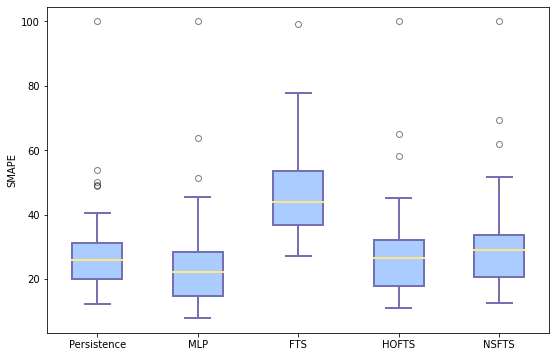

In [ ]:
metric = 'SMAPE'
results_data = [persistence_results[metric],mlp_results[metric], fts_results[metric], hofts_results[metric], nsfts_results[metric]]
xticks = ['Persistence','MLP','FTS','HOFTS','NSFTS']

ylab = 'SMAPE'
createBoxplot("nsfts_boxplot_smape_wind", results_data, xticks, ylab)

In [ ]:
metric = 'SMAPE'
smape_df = pd.DataFrame(columns=['Persistence','MLP','FTS','HOFTS','NSFTS'])

smape_df["Persistence"] = persistence_results[metric]
smape_df["MLP"] = mlp_results[metric]
smape_df["FTS"] = fts_results[metric]
smape_df["HOFTS"] = hofts_results[metric]
smape_df["NSFTS"] = nsfts_results[metric]

In [ ]:
print("Mean")
print(smape_df.mean())
print("std")
print(smape_df.std())

Mean
Persistence   28.3633
MLP           24.5248
FTS           47.3436
HOFTS         28.3644
NSFTS         30.4681
dtype: float64
std
Persistence   14.3074
MLP           15.5393
FTS           14.9635
HOFTS         15.4281
NSFTS         15.4127
dtype: float64
